# Correlation between subcellular regions

The `rc` (region correlation) module provides metrics to assess how well subcellular regions (e.g. cell and nucleus) align. 

To follow along with this tutorial, you can download the data from [here](https://oc.embl.de/index.php/s/1JyN4Qvk4mw0T5J).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spatialdata as sd
import spatialdata_plot  # noqa

import segtraq

sdata_ws = sd.read_zarr("../../data/xenium.zarr")

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: Fut

The SpatialData object is subset for better visualization.

In [3]:
bb_xmin = 800
bb_ymin = 1150
bb_w = 200
bb_h = 300
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


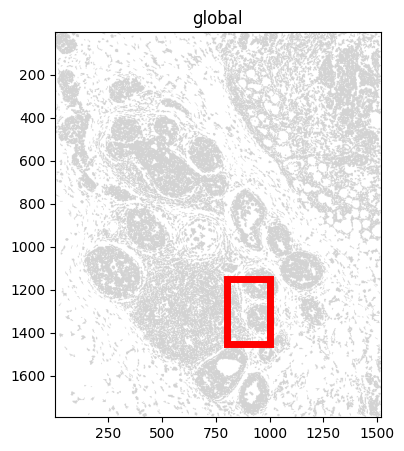

In [4]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5, 5))
sdata_ws.pl.render_shapes("cell_boundaries").pl.show(ax=ax)
rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none")
ax.add_patch(rect)

In [5]:
sdata = sdata_ws.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

/home/meyerben/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/functools.py:934: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


Next, the `SegTraQ` object is initialized.

In [7]:
st = segtraq.SegTraQ(sdata, images_key="image", tables_x_key="x_centroid", tables_y_key="y_centroid")

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/SegTraQ.py:128: UserWarning: Missing 8 cell IDs in tables: ['icefbjdk-1', 'iceeeemj-1', 'icealcci-1', 'aphemnlm-1', 'icdokine-1']... These cells are present in shapes, but not in tables. This might lead to inconsistencies in the spatialdata object.
  validate_spatialdata(


The `spatialdata`dataset contains cell and nuclear masks as `Shapes`and `Labels`, as shown below.

## Intersection over Union between cell and nucleus masks

First, we compute the Intersection over Union (IoU) between cell and nuclear masks using `compute_cell_nuc_ious`. It is applicable only when nuclear masks are available.

In [7]:
import time

n = 1

start = time.time()
results_df = st.rc.compute_cell_nuc_ious(n_jobs=n)
end = time.time()

print(f"Elapsed time with {n} threads: {end - start:.2f} seconds")

Processing IoU between cells and nuclei: 100%|██████████| 751/751 [00:00<00:00, 1075.70it/s]

Elapsed time with 1 threads: 0.70 seconds


For each `cell_id`, we obtain the ID (`best_nuc_id`) of the nucleus mask with the highest `IoU`. If a cell does not overlap with any nucleus, the function returns a missing value for `best_nuc_id`. If the nucleus has an invalid geometry, `IoU`is reported as `NA`.

In [8]:
results_df

cell_id  best_nuc_id       IoU
0    aphcnklp-1       3979.0  0.483171
1    aphdnoam-1          NaN  0.000000
2    aphdpfhl-1       3996.0  0.708233
3    aphebebn-1       3999.0  0.553658
4    aphejokb-1       4005.0  0.503665
..          ...          ...       ...
746  oemhhakm-1      18551.0  1.000000
747  oemhhohn-1      18552.0  1.000000
748  oemhjdii-1      18553.0  1.000000
749  oemhkbjo-1      18554.0  1.000000
750  oemidopc-1      18557.0  1.000000

[751 rows x 3 columns]

Coloring cell boundaries by annotation (in this case IoU) will not work, if annotation has missing values (invalid geometries). Thus, we exclude them for plotting.

In [9]:
import copy

sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][sdata_plot["table"].obs["IoU"].notna()]

In the spatial plots, we can see that cells that have a high overlap with nuclei, also show a high IoU value. 

/tmp/ipykernel_953991/2438805429.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:482: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


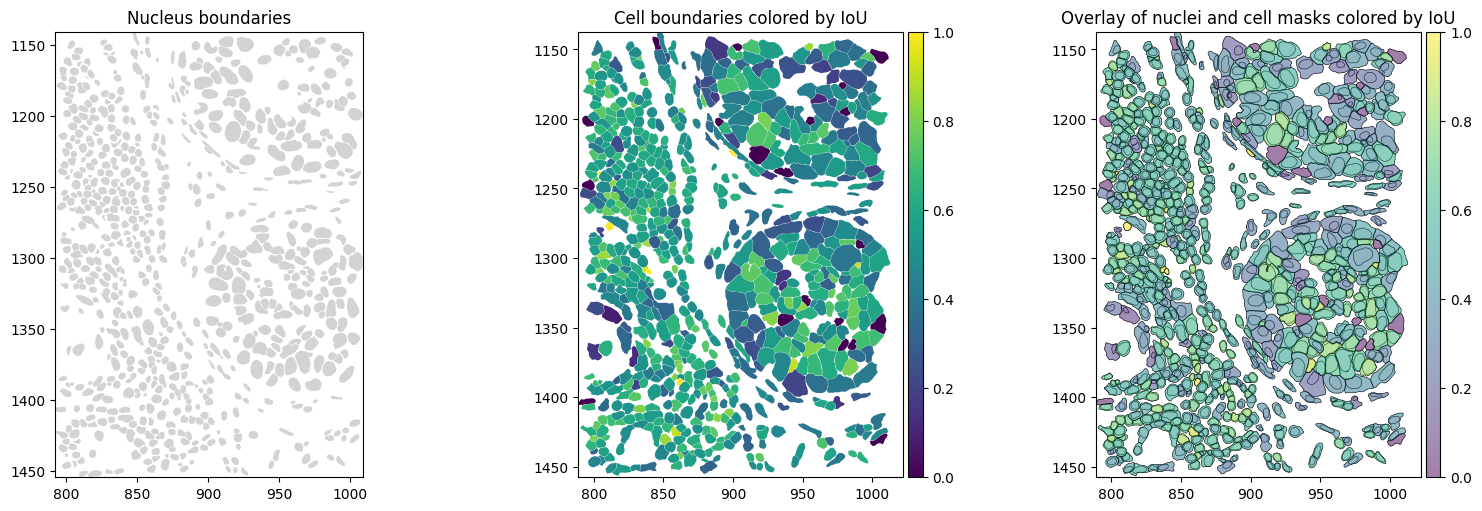

In [10]:
axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)[1].flatten()

# link annotations with cell boundaries
sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries")

# plot
sdata_plot.pl.render_shapes("nucleus_boundaries").pl.show(
    ax=axes[0], title="Nucleus boundaries", coordinate_systems="global"
)

sdata_plot.pl.render_shapes("cell_boundaries", color="IoU").pl.show(
    ax=axes[1], title="Cell boundaries colored by IoU", coordinate_systems="global"
)

sdata_plot.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="IoU",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.show(ax=axes[2], title="Overlay of nuclei and cell masks colored by IoU", colorbar=True)

The histogram of IoU distribution (below) shows a median IoU is at 0.5, i.e. 50% overlap. 

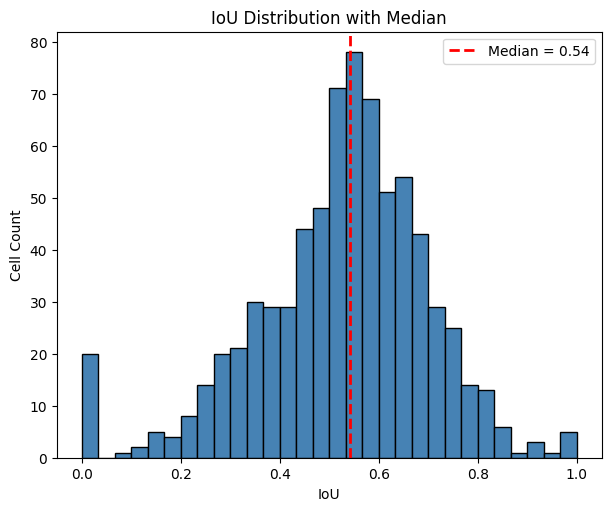

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare IoU values
ious = sdata["table"].obs["IoU"].dropna()
median_iou = np.median(ious)

# Set up figure with histogram
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot histogram
ax.hist(ious, bins=30, color="steelblue", edgecolor="black")

# Add median line
ax.axvline(
    median_iou,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_iou:.2f}",
)

# Decorate
ax.set_title("IoU Distribution with Median")
ax.set_xlabel("IoU")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

## Expression correlation between cell and nucleus

Expression correlation between a cell and the "most-overlapping" nucleus can be computed using `compute_cell_nuc_correlation`. It is applicable only when nuclear masks are available. This function will internally compute `IoU` using `compute_cell_nuc_ious` unless already present in the `spatialdata`object. Currently only `pearson`correlation is supported. More options will be added later. 

In [12]:
start = time.time()
corr_df = st.rc.compute_cell_nuc_correlation(metric="cosine_sim")
end = time.time()

print(f"Elapsed time without computing IoU: {end - start:.2f} seconds")

Elapsed time without computing IoU: 1.03 seconds


In [13]:
corr_df

(        cell_id  best_nuc_id       IoU  corr_nc_cell
 0    aphcnklp-1       3979.0  0.483171      0.556305
 1    aphdnoam-1          NaN  0.000000      0.000000
 2    aphdpfhl-1       3996.0  0.708233      0.420162
 3    aphebebn-1       3999.0  0.553658      0.599645
 4    aphejokb-1       4005.0  0.503665      0.772827
 ..          ...          ...       ...           ...
 738  oemhhakm-1      18551.0  1.000000      0.816497
 739  oemhhohn-1      18552.0  1.000000           NaN
 740  oemhjdii-1      18553.0  1.000000      0.925820
 741  oemhkbjo-1      18554.0  1.000000      0.953405
 742  oemidopc-1      18557.0  1.000000      0.953463
 
 [743 rows x 4 columns],
           cell_id  best_nuc_id       IoU
 3774   aphcnklp-1       3979.0  0.483171
 3790   aphdnoam-1          NaN  0.000000
 3791   aphdpfhl-1       3996.0  0.708233
 3793   aphebebn-1       3999.0  0.553658
 3801   aphejokb-1       4005.0  0.503665
 ...           ...          ...       ...
 18253  oemhhakm-1      18551.0

The histogram below shows the distribution of cosine similarity values across cells. It is right-skewed, with a median of 0.75. This provides intuition about possible spatial spillover: cells may be contaminated by neighboring cells, assuming that nuclei capture expression with less contamination due to their smaller radius.

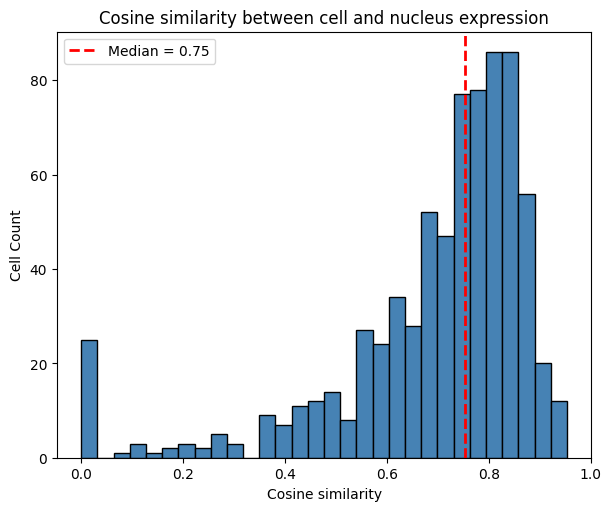

In [14]:
# Prepare corr values
obs = sdata["table"].obs
corr = obs["corr_nc_cell"].dropna()
median_corr = np.median(corr)

# Set up figure with histogram
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot histogram
ax.hist(corr, bins=30, color="steelblue", edgecolor="black")

# Add median line
ax.axvline(
    median_corr,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_corr:.2f}",
)

# Decorate
ax.set_title("Cosine similarity between cell and nucleus expression")
ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

The calculated R2 (coefficient of determination) is 0.400 indicating that correlation between cell and nucleus increases with their IoU. 

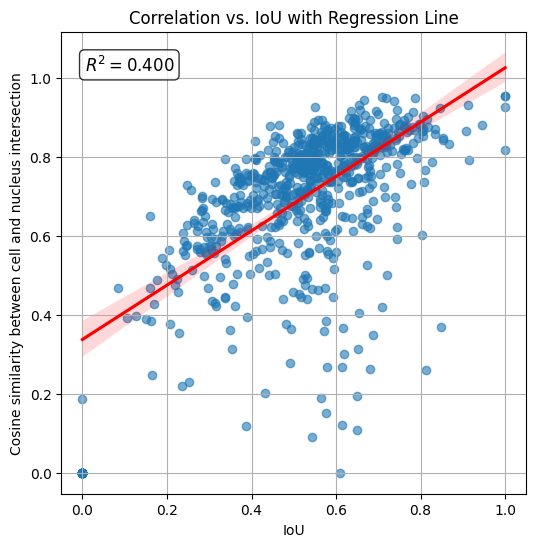

In [15]:
import seaborn as sns
from scipy.stats import linregress

# Extract the relevant columns, excluding NaNs
df = obs[["IoU", "corr_nc_cell"]].dropna()

# Compute regression metrics
slope, intercept, r_value, p_value, std_err = linregress(df["IoU"], df["corr_nc_cell"])
r_squared = r_value**2

# Create the plot
plt.figure(figsize=(6, 6))
ax = sns.regplot(
    data=df,
    x="IoU",
    y="corr_nc_cell",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    ci=95,
)

# Overlay the R² value
ax.text(
    0.05,
    0.95,
    f"$R^2 = {r_squared:.3f}$",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

ax.set_xlabel("IoU")
ax.set_ylabel("Cosine similarity between cell and nucleus intersection")
ax.set_title("Correlation vs. IoU with Regression Line")
ax.grid(True)

plt.show()

The spatial plot below overlays nucleus boundaries, cell masks colored by Pearson correlation, and transcripts. Cells whose transcripts are distributed across the nucleus region tend to have higher correlation with the nucleus, while cells whose transcripts are localized outside the nuclear region—potentially due to spillover from neighboring cells—tend to exhibit lower correlation.

In [16]:
# filter out entries with NaN correlation for plotting
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][
    (sdata_plot["table"].obs["corr_nc_cell"].notna() & sdata_plot["table"].obs["IoU"].notna())
]

/tmp/ipykernel_953991/575072355.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:482: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)
/home/lazic/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/render.py:821: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _c

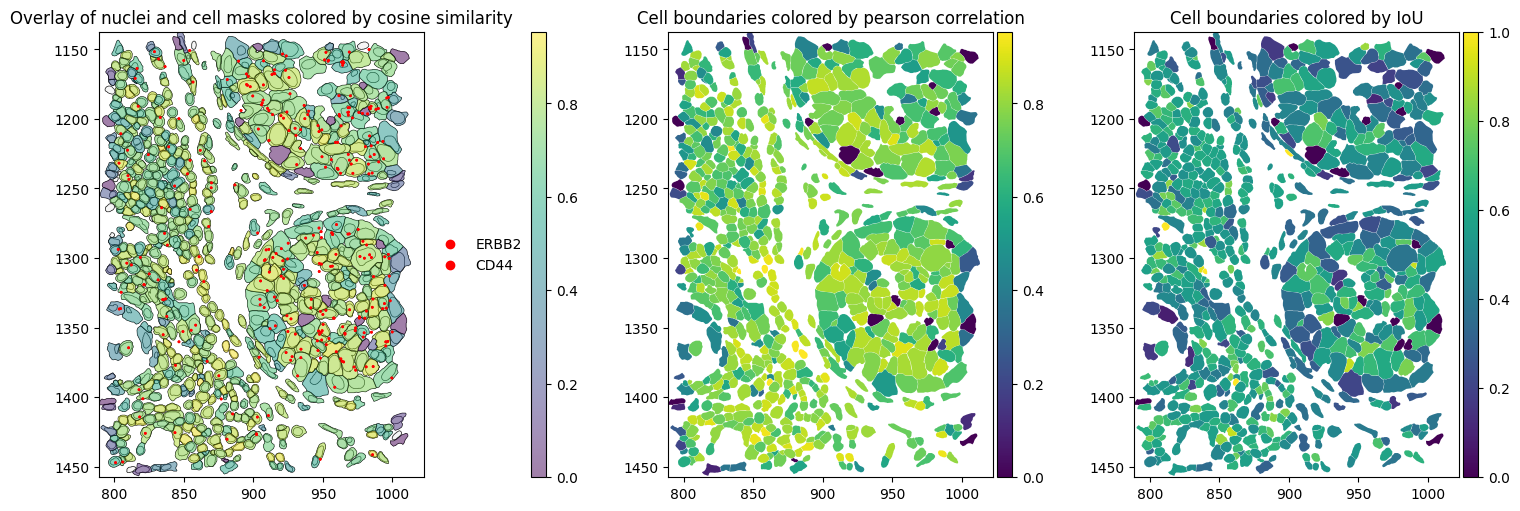

In [17]:
# link annotations with cell boundaries
sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries")

axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)[1].flatten()

sdata_plot.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="corr_nc_cell",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups=["ERBB2", "CD44", "PTPRC"],
    palette=["red", "red", "red"],
).pl.show(
    ax=axes[0],
    title="Overlay of nuclei and cell masks colored by cosine similarity",
    colorbar=True,
    figsize=(6, 6),
)


sdata_plot.pl.render_shapes("cell_boundaries", color="corr_nc_cell").pl.show(
    ax=axes[1], title="Cell boundaries colored by pearson correlation", coordinate_systems="global"
)

sdata_plot.pl.render_shapes("cell_boundaries", color="IoU").pl.show(
    ax=axes[2], title="Cell boundaries colored by IoU", coordinate_systems="global"
)

## Correlation between Intersection and Remainder Parts of the Cell

The function `compute_correlation_between_parts()` computes the cosine similarity between the spatial transcript feature counts within the intersection of a cell and its matched nucleus, and the remainder of the cell. It is applicable only when nuclear masks are available. It returns `NaN` when the regions have no overlapping transcripts or lack sufficient variability. A low correlation may indicate that the cell boundary extension captures neighborhood or ambient signal rather than true intracellular expression—a concern similarly highlighted by segmentation benchmarks such as [Baysor](https://www.nature.com/articles/s41587-021-01044-w). This is based on the assumption that transcripts are homogeneously distributed within the cell and not localized in specific subcellular regions. 

In [18]:
# %load_ext line_profiler


# %lprun -f nc.compute_correlation_between_parts st.rc.compute_correlation_between_parts()

In [19]:
# import cProfile
# import pstats

# with cProfile.Profile() as pr:
#     st.rc.compute_correlation_between_parts()

# stats = pstats.Stats(pr)
# stats.sort_stats("cumtime").print_stats(40)  # top 40 slowest functions

In [20]:
start = time.time()
corr_parts_df = st.rc.compute_correlation_between_parts(metric="cosine_sim")
end = time.time()

print(f"Elapsed time without computing IoU: {end - start:.2f} seconds")

/g/huber/users/lazic/src/SegTraQ/src/segtraq/rc/region_correlation.py:430: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([points_cell_id_key, points_gene_key])
/g/huber/users/lazic/src/SegTraQ/src/segtraq/rc/region_correlation.py:438: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([points_cell_id_key, points_gene_key])


for loop done
Elapsed time without computing IoU: 1.12 seconds


In [21]:
corr_parts_df

cell_id  best_nuc_id       IoU  correlation_parts
0    aphcnklp-1       3979.0  0.483171           0.122292
1    aphdnoam-1          NaN  0.000000                NaN
2    aphdpfhl-1       3996.0  0.708233           0.105932
3    aphebebn-1       3999.0  0.553658           0.170825
4    aphejokb-1       4005.0  0.503665           0.155276
..          ...          ...       ...                ...
738  oemhhakm-1      18551.0  1.000000           0.000000
739  oemhhohn-1      18552.0  1.000000                NaN
740  oemhjdii-1      18553.0  1.000000                NaN
741  oemhkbjo-1      18554.0  1.000000           0.312859
742  oemidopc-1      18557.0  1.000000                NaN

[743 rows x 4 columns]

The histogram below shows that the cosine similarity between the intersection and remainder region of the cell is 0.08. 

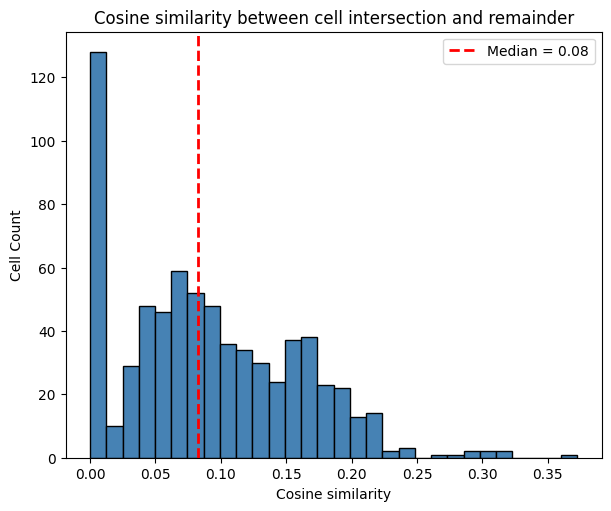

In [22]:
obs = sdata["table"].obs
# Prepare corr_parts values
corr = obs["correlation_parts"].dropna()
median_corr_parts = corr.median()

# Set up figure with histogram
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot histogram
ax.hist(corr, bins=30, color="steelblue", edgecolor="black")

# Add median line
ax.axvline(
    median_corr_parts,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_corr_parts:.2f}",
)

# Decorate
ax.set_title("Cosine similarity between cell intersection and remainder")
ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

The scatter plot below visualizes the cosine similarity between transcript counts in the intersection and remainder of each cell, plotted against the Intersection over Union (IoU) with the nucleus. The calculated R2 (coefficient of determination) value is 0.007, indicating that IoU explains less than 1% of the variance in correlation. This negligible relationship suggests that normalization of the correlation metric by IoU is not necessary.

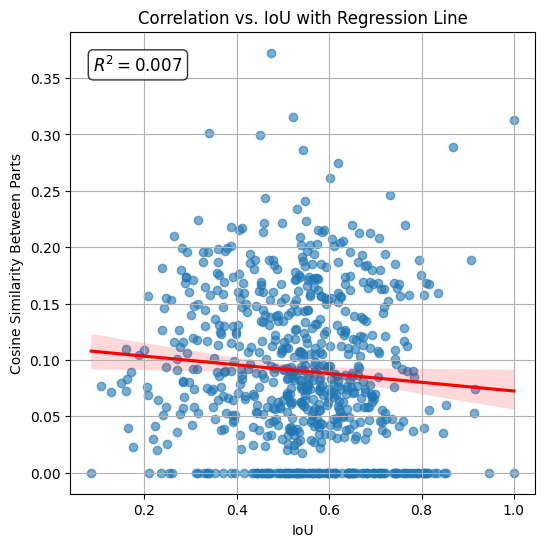

In [23]:
import seaborn as sns

# Extract the relevant columns, excluding NaNs
df = obs[["IoU", "correlation_parts"]].dropna()

# Compute regression metrics
slope, intercept, r_value, p_value, std_err = linregress(df["IoU"], df["correlation_parts"])
r_squared = r_value**2

# Create the plot
plt.figure(figsize=(6, 6))
ax = sns.regplot(
    data=df,
    x="IoU",
    y="correlation_parts",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    ci=95,
)

# Overlay the R² value
ax.text(
    0.05,
    0.95,
    f"$R^2 = {r_squared:.3f}$",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

ax.set_xlabel("IoU")
ax.set_ylabel("Cosine Similarity Between Parts")
ax.set_title("Correlation vs. IoU with Regression Line")
ax.grid(True)

plt.show()

Because `spatialdata-plot` plots all boundaries in grey, if there are NaN values in the annotation (describe [before](https://github.com/scverse/spatialdata-plot/pull/87)), we will copy the `correlation_parts` column and set `NaN`values to `0.0`just for plotting. We will try to solve this issue later. 

In [47]:
# filter out entries with NaN correlation for plotting
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][
    (sdata_plot["table"].obs["corr_nc_cell"].notna() & sdata_plot["table"].obs["correlation_parts"].notna())
]

The spatial plots below shows the spatial distribution of computed correlations. The Pearson correlation between parts can be a measure of how much neighboring signal is captured. 

/tmp/ipykernel_830327/3823815026.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:482: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)
/home/lazic/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/render.py:821: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _c

INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)
/home/lazic/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/render.py:821: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _c

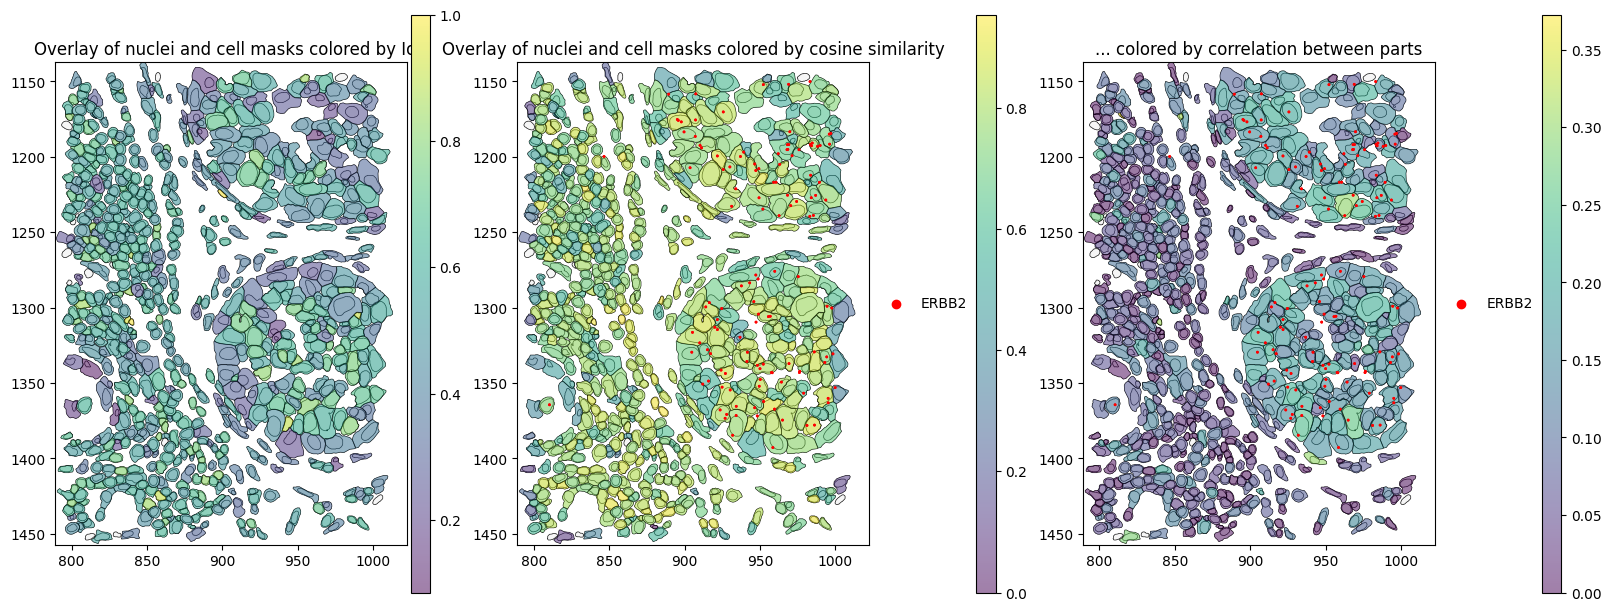

In [48]:
# link annotations with cell boundaries
sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries")

axes = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)[1].flatten()

sdata_plot.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_width=0.5,
    outline_alpha=1.0,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="IoU",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.show(
    ax=axes[0],
    title="Overlay of nuclei and cell masks colored by IoU",
    colorbar=True,
    figsize=(6, 6),
)

sdata_plot.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="corr_nc_cell",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups="ERBB2",
    palette="red",
).pl.show(
    ax=axes[1],
    title="Overlay of nuclei and cell masks colored by cosine similarity",
    colorbar=True,
    figsize=(6, 6),
)

sdata_plot.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_width=0.5,
    outline_alpha=1.0,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="correlation_parts",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups="ERBB2",
    palette="red",
).pl.show(
    ax=axes[2],
    title="... colored by correlation between parts",
    colorbar=True,
    figsize=(6, 6),
)

## Correlation cell border with its center and its neigbhorhood
The function `compute_correlation_between_parts()` computes the cosine similarity between (1) the cell border and an eroded interior and (2) the cell border and the immediate neighborhood.     Specifically, the function:
1. Erodes each cell polygon to obtain a center region.
2. Defines the border region as the set difference between the full cell
   and its eroded center.
3. Computes gene expression profiles for center and border.
4. Computes the correlation between center and border expression.
5. Computes the correlation between border expression and the
   NCV expression profile of the same cell.
6. The ratio of the latter two

In [49]:
start = time.time()
corr_center_border_ncv_df = st.rc.compute_center_border_ncv_correlation()
end = time.time()

print(f"Elapsed time without computing IoU: {end - start:.2f} seconds")

/g/huber/users/lazic/src/SegTraQ/src/segtraq/rc/utils.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region_id", points_gene_key])
/g/huber/users/lazic/src/SegTraQ/src/segtraq/rc/utils.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region_id", points_gene_key])


Elapsed time without computing IoU: 2.02 seconds


The histogram below shows the distribution of the correlation between the cell center and border.

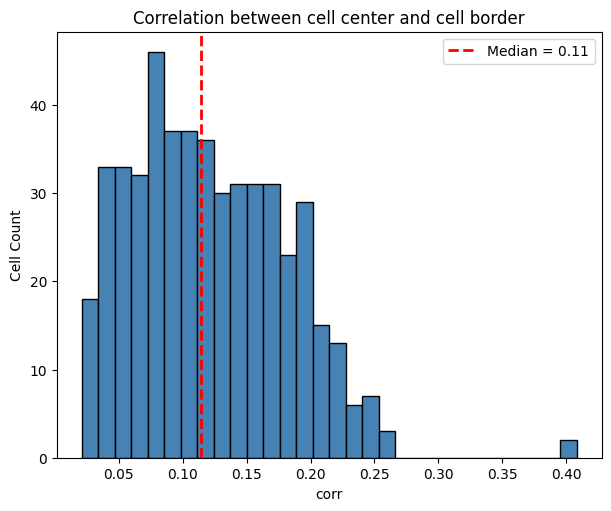

In [50]:
corr = sdata["table"].obs["corr_center_border"].dropna()
median_iou = np.median(corr)

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

ax.hist(corr, bins=30, color="steelblue", edgecolor="black")

ax.axvline(
    median_iou,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_iou:.2f}",
)

ax.set_title("Correlation between cell center and cell border")
ax.set_xlabel("corr")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

The histogram below shows the distribution of the correlation between the cell border and its neigbhorhood (with a distance of twice cell radius from its centroid). As expected, the correlation to the cell center is higher than to the cell neighborhood. This will differ depending on whether the cell is located within a homogeneous or a heterogeneous neighborhood.

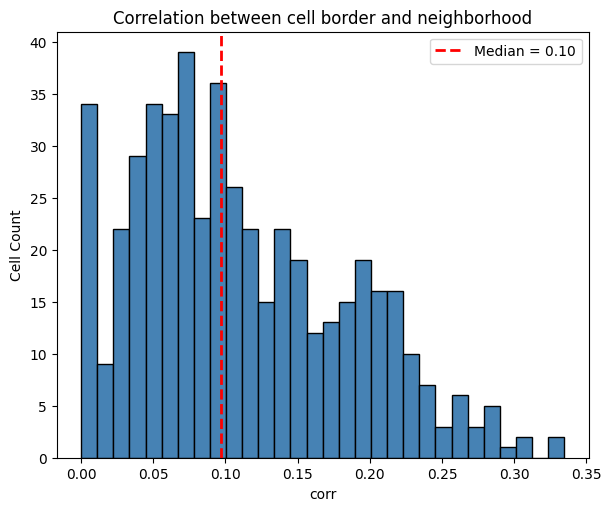

In [51]:
corr = sdata["table"].obs["corr_border_ncv"].dropna()
median_iou = np.median(corr)

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

ax.hist(corr, bins=30, color="steelblue", edgecolor="black")

ax.axvline(
    median_iou,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_iou:.2f}",
)

ax.set_title("Correlation between cell border and neighborhood")
ax.set_xlabel("corr")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

The scatter plot below visualizes the cosine similarity between the cell border and its neigbhorhood plotted against the cosine simiarity between the cell border and cell center. The calculated R2 (coefficient of determination) value is 0.38. 

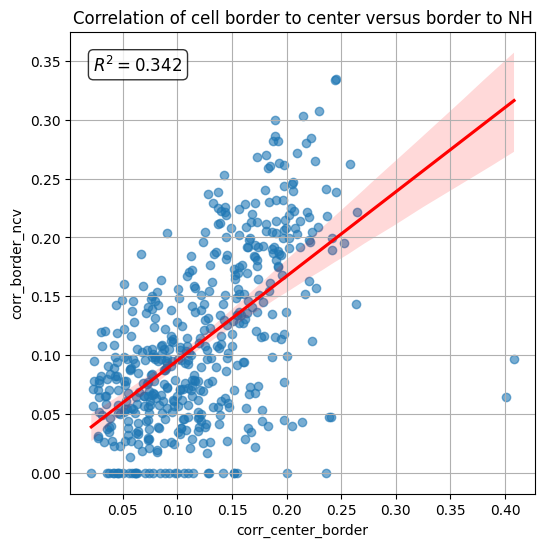

In [52]:
obs = sdata["table"].obs
# Extract the relevant columns, excluding NaNs
df = obs[["corr_center_border", "corr_border_ncv"]].dropna()

# Compute regression metrics
slope, intercept, r_value, p_value, std_err = linregress(df["corr_center_border"], df["corr_border_ncv"])
r_squared = r_value**2

# Create the plot
plt.figure(figsize=(6, 6))
ax = sns.regplot(
    data=df,
    x="corr_center_border",
    y="corr_border_ncv",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    ci=95,
)

# Overlay the R² value
ax.text(
    0.05,
    0.95,
    f"$R^2 = {r_squared:.3f}$",
    transform=ax.transAxes,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

ax.set_xlabel("corr_center_border")
ax.set_ylabel("corr_border_ncv")
ax.set_title("Correlation of cell border to center versus border to NH")
ax.grid(True)

plt.show()

The spatial plots below shows the spatial distribution of computed correlations. 

In [53]:
# filter out entries with NaN correlation for plotting
sdata_plot = copy.deepcopy(sdata)
sdata_plot["table"] = sdata_plot["table"][
    (sdata_plot["table"].obs["corr_center_border"].notna() & sdata_plot["table"].obs["corr_border_ncv"].notna())
]

/tmp/ipykernel_830327/4198321451.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:482: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)
/home/lazic/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/render.py:821: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _c

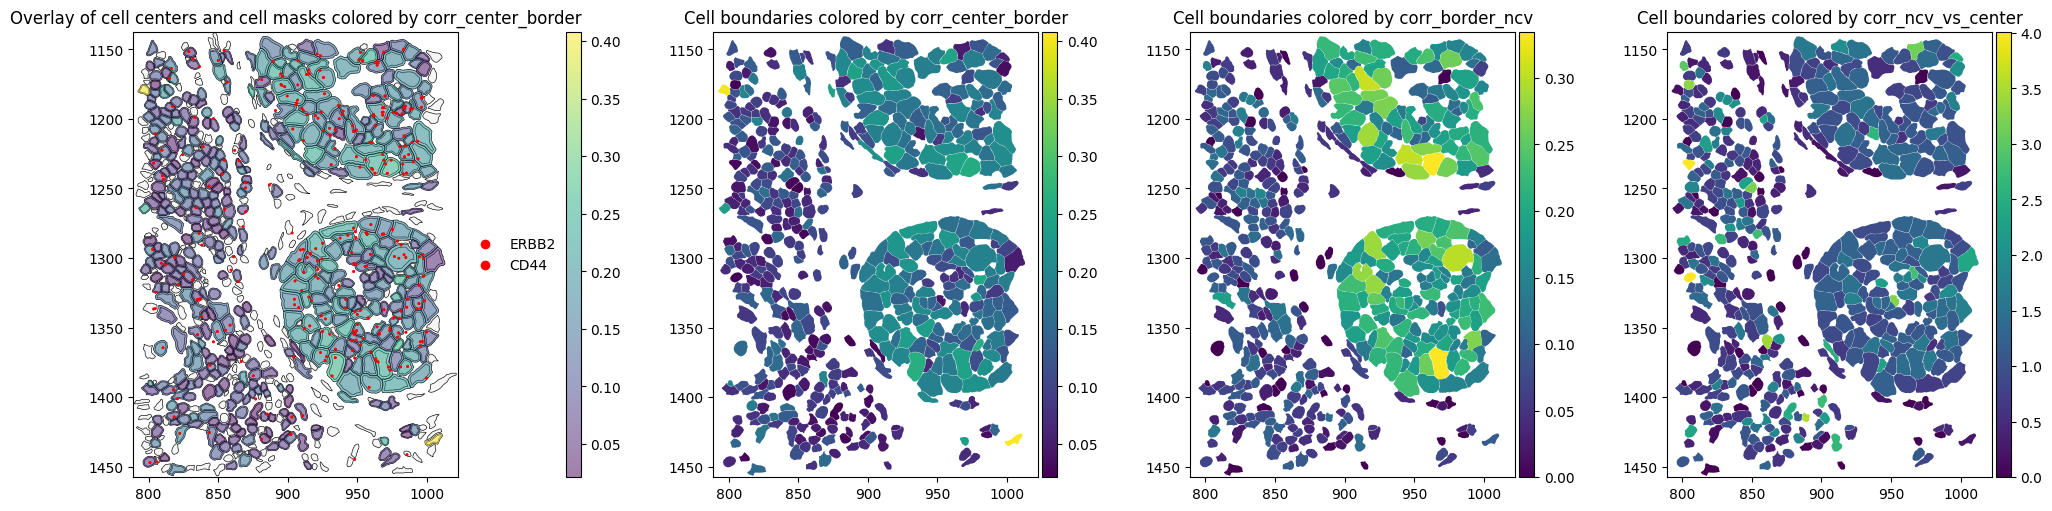

In [54]:
# link annotations with cell boundaries
sdata_plot.tables["table"].obs["region"] = "cell_boundaries"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries")

axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)[1].flatten()

sdata_plot.pl.render_shapes(
    element="cell_centers",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="corr_center_border",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups=["ERBB2", "CD44", "PTPRC"],
    palette=["red", "red", "red"],
).pl.show(
    ax=axes[0],
    title="Overlay of cell centers and cell masks colored by corr_center_border",
    colorbar=True,
    figsize=(6, 6),
)


sdata_plot.pl.render_shapes("cell_boundaries", color="corr_center_border").pl.show(
    ax=axes[1], title="Cell boundaries colored by corr_center_border", coordinate_systems="global"
)

sdata_plot.pl.render_shapes("cell_boundaries", color="corr_border_ncv").pl.show(
    ax=axes[2], title="Cell boundaries colored by corr_border_ncv", coordinate_systems="global"
)

sdata_plot.pl.render_shapes("cell_boundaries", color="corr_ncv_vs_center").pl.show(
    ax=axes[3], title="Cell boundaries colored by corr_ncv_vs_center", coordinate_systems="global"
)

All of the metrics are also stored in the spatialdata object.

In [55]:
sdata.tables["table"]

AnnData object with n_obs × n_vars = 743 × 5101
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'label_id', 'region', 'corr_nc_cell', 'best_nuc_id', 'IoU', 'correlation_parts', 'corr_center_border', 'corr_border_ncv', 'corr_ncv_vs_center'
    uns: 'spatialdata_attrs'

Alternatively, all `nc` metrics can be computed in one run via `run_region_correlation`.

In [56]:
st.run_region_correlation()
sdata.tables["table"].obs.head()

Processing IoU between cells and nuclei:   0%|          | 0/751 [00:00<?, ?it/s]Processing IoU between cells and nuclei: 100%|██████████| 751/751 [00:00<00:00, 1078.03it/s]


cell_id  x_centroid   y_centroid  transcript_counts  \
3774  aphcnklp-1  830.097471  1152.572969                 66   
3790  aphdnoam-1  903.576230  1148.448945                101   
3791  aphdpfhl-1  913.759580  1148.394258                298   
3793  aphebebn-1  926.788389  1150.407930                464   
3801  aphejokb-1  976.144590  1181.338594                225   

      control_probe_counts  genomic_control_counts  control_codeword_counts  \
3774                     0                       0                        0   
3790                     0                       0                        0   
3791                     0                       0                        0   
3793                     0                       0                        0   
3801                     0                       0                        0   

      unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
3774                           0                          13            79   
3790                           0                          16           117   
3791                           0                          59           357   
3793                           0                          96           560   
3801                           0                          34           259   

      ...                                segmentation_method  label_id  \
3774  ...  Segmented by boundary stain (ATP1A1+CD45+E-Cad...      3775   
3790  ...  Segmented by boundary stain (ATP1A1+CD45+E-Cad...      3791   
3791  ...  Segmented by boundary stain (ATP1A1+CD45+E-Cad...      3792   
3793  ...  Segmented by boundary stain (ATP1A1+CD45+E-Cad...      3794   
3801  ...  Segmented by boundary stain (ATP1A1+CD45+E-Cad...      3802   

           region corr_nc_cell  best_nuc_id       IoU  correlation_parts  \
3774  cell_labels     0.556305       3979.0  0.483171           0.122292   
3790  cell_labels     0.000000          NaN  0.000000                NaN   
3791  cell_labels     0.420162       3996.0  0.708233           0.105932   
3793  cell_labels     0.599645       3999.0  0.553658           0.170825   
3801  cell_labels     0.772827       4005.0  0.503665           0.155276   

      corr_center_border  corr_border_ncv  corr_ncv_vs_center  
3774            0.039647         0.027246            0.687230  
3790                 NaN              NaN                 NaN  
3791            0.076383         0.149833            1.961611  
3793            0.137321         0.211625            1.541098  
3801            0.183475         0.154443            0.841766  

[5 rows x 23 columns]